In [2]:
%matplotlib inline

cuda:0


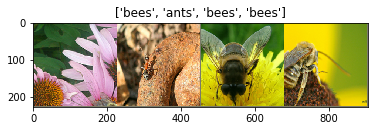

Epoch: 1/25
----------
train Loss: 0.5439 Acc: 0.6926
val Loss: 0.2055 Acc: 0.9346

Epoch: 2/25
----------
train Loss: 0.5458 Acc: 0.7623
val Loss: 0.2428 Acc: 0.8824

Epoch: 3/25
----------
train Loss: 0.5057 Acc: 0.7869
val Loss: 0.2696 Acc: 0.9020

Epoch: 4/25
----------
train Loss: 0.4209 Acc: 0.8402
val Loss: 0.3102 Acc: 0.8824

Epoch: 5/25
----------
train Loss: 0.3831 Acc: 0.8402
val Loss: 0.4566 Acc: 0.8301

Epoch: 6/25
----------
train Loss: 0.4016 Acc: 0.8320
val Loss: 0.4899 Acc: 0.8301

Epoch: 7/25
----------
train Loss: 0.4503 Acc: 0.8443
val Loss: 0.3236 Acc: 0.8627

Epoch: 8/25
----------
train Loss: 0.3733 Acc: 0.8361
val Loss: 0.3338 Acc: 0.8562

Epoch: 9/25
----------
train Loss: 0.3973 Acc: 0.8484
val Loss: 0.3191 Acc: 0.8627

Epoch: 10/25
----------
train Loss: 0.2584 Acc: 0.8689
val Loss: 0.2794 Acc: 0.8889

Epoch: 11/25
----------
train Loss: 0.3453 Acc: 0.8607
val Loss: 0.3002 Acc: 0.8954

Epoch: 12/25
----------
train Loss: 0.3192 Acc: 0.8730
val Loss: 0.2864 Ac

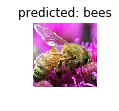

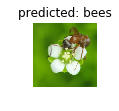

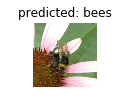

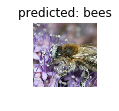

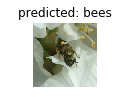

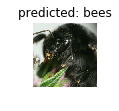

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

data_transforms = {
    'train': transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                        data_transforms[x])
                                for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                batch_size=4, shuffle=True, num_workers=4)
                for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)



inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

def imshow(inp, title=None):
        inp = inp.numpy().transpose((1,2,0))
        mean = np.array([0.485, 0.486, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)


imshow(out, title=[class_names[x] for x in classes])

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch: {epoch+1}/{num_epochs}')
        print('-'*10)

        # Training and Validation
        for phase in ['train','val']:
            if phase == 'train':
                scheduler.step()
                model.train()   # Set to train mode
            else: 
                model.eval()    # Set to Eval mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Set the gradient only if in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # If training phase, backpropogate and optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep Copy Model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #Load best model weights into model
    model.load_state_dict(best_model_wts)
    return model


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return 
        model.train(was_training)


model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()


optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

visualize_model(model_ft)


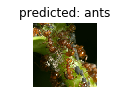

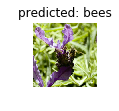

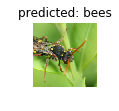

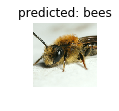

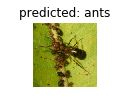

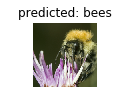

In [4]:
visualize_model(model_ft)

In [9]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [10]:
model_conv

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch: 1/25
----------
train Loss: 0.6295 Acc: 0.6393
val Loss: 0.2167 Acc: 0.9346

Epoch: 2/25
----------
train Loss: 0.4481 Acc: 0.8115
val Loss: 0.2099 Acc: 0.9216

Epoch: 3/25
----------
train Loss: 0.4269 Acc: 0.8238
val Loss: 0.1831 Acc: 0.9542

Epoch: 4/25
----------
train Loss: 0.9203 Acc: 0.6639
val Loss: 0.3644 Acc: 0.8627

Epoch: 5/25
----------
train Loss: 0.4051 Acc: 0.8279
val Loss: 0.1609 Acc: 0.9542

Epoch: 6/25
----------
train Loss: 0.4204 Acc: 0.8279
val Loss: 0.2572 Acc: 0.9085

Epoch: 7/25
----------
train Loss: 0.3770 Acc: 0.8279
val Loss: 0.1918 Acc: 0.9346

Epoch: 8/25
----------
train Loss: 0.3329 Acc: 0.8770
val Loss: 0.2139 Acc: 0.9150

Epoch: 9/25
----------
train Loss: 0.3304 Acc: 0.8443
val Loss: 0.1808 Acc: 0.9216

Epoch: 10/25
----------
train Loss: 0.3718 Acc: 0.8197
val Loss: 0.1996 Acc: 0.9216

Epoch: 11/25
----------
train Loss: 0.3476 Acc: 0.8279
val Loss: 0.2333 Acc: 0.9085

Epoch: 12/25
----------
train Loss: 0.3350 Acc: 0.8525
val Loss: 0.1932 Ac

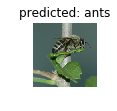

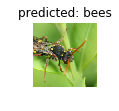

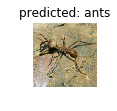

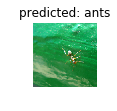

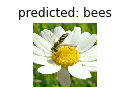

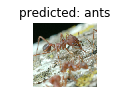

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()